In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

import tf_lab.point_clouds.in_out as pio
import tf_lab.models.point_net_based_AE as pnAE

from tf_lab.fundamentals.utils import set_visible_GPUs

from tf_lab.point_clouds.in_out import PointCloudDataSet
from tf_lab.point_clouds.vae import VariationalAutoencoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.various_encoders_decoders as enc_dec
from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, match_incomplete_to_complete_data

from tf_lab.autopredictors.evaluate.basics import eval_model, read_saved_epochs
from tf_lab.autopredictors.plotting.basics import plot_original_pclouds_vs_reconstructed,\
                                                  plot_train_val_test_curves, plot_reconstructions_at_epoch


from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from geo_tool import Point_Cloud

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
class_type = raw_input('Give me the class type.\n').lower()
class_syn_id = shape_net_category_to_synth_id()[class_type]
experiment_name = 'chamfer_full_shapes_' + class_syn_id + '_vae'

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'ShapeNetPointClouds/from_manifold_meshes/1024/', class_syn_id)

train_dir = osp.join(top_data_dir, 'OUT/models/variational')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

Give me the class type.
chair


'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/variational/chamfer_full_shapes_03001627_vae'

In [4]:
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path)
full_pclouds, full_model_names, class_ids = pio.load_crude_point_clouds(file_names=full_file_names, n_threads=15)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

6778 files containing complete point clouds were found.


In [5]:
train_data_, val_data_, test_data_ = pio.train_validate_test_split([full_pclouds, 
                                                                    full_model_names],
                                                                    train_perc=0.95,
                                                                    validate_perc=0.0,
                                                                    test_perc=0.05,                                                                   
                                                                    seed=seed)

train_data = PointCloudDataSet(train_data_[0], labels=train_data_[1])
test_data = PointCloudDataSet(test_data_[0], labels=test_data_[1])

In [48]:
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

set_visible_GPUs([0])

conf = Conf(n_input = [1024, 3],
            training_epochs = 1000,
            batch_size = 50,
            loss = 'chamfer',
            train_dir = train_dir,
            loss_display_step = 1,
            saver_step = 5,
            learning_rate = 0.0001,
            saver_max_to_keep = 200,
            gauss_augment = {'mu': 0, 'sigma': 0.05},
            encoder = enc_dec.encoder_1dcovnv_5_points,
            decoder = enc_dec.decoder_only_with_fc,
            spatial_trans = True,
            denoising = False,
            n_z = 200,
            latent_vs_recon = 1,
            z_rotate = True
           )

reset_graph()
vae = VariationalAutoencoder(experiment_name, conf)
vae.train(train_data, conf)

('Epoch:', '0001', 'training time (minutes)=', '0.0884', 'loss=', '1091.638248920')
('Epoch:', '0002', 'training time (minutes)=', '0.0794', 'loss=', '449.669453382')
('Epoch:', '0003', 'training time (minutes)=', '0.0886', 'loss=', '428.043596506')
('Epoch:', '0004', 'training time (minutes)=', '0.0880', 'loss=', '389.671762705')
('Epoch:', '0005', 'training time (minutes)=', '0.0812', 'loss=', '378.999552488')
('Epoch:', '0006', 'training time (minutes)=', '0.0902', 'loss=', '383.359614849')
('Epoch:', '0007', 'training time (minutes)=', '0.0790', 'loss=', '364.830331802')
('Epoch:', '0008', 'training time (minutes)=', '0.0840', 'loss=', '362.668877125')
('Epoch:', '0009', 'training time (minutes)=', '0.0803', 'loss=', '354.547694683')
('Epoch:', '0010', 'training time (minutes)=', '0.0801', 'loss=', '340.257535219')
('Epoch:', '0011', 'training time (minutes)=', '0.0834', 'loss=', '330.542335033')
('Epoch:', '0012', 'training time (minutes)=', '0.0830', 'loss=', '334.546340466')
('E

[(1, 1091.6382489204407, 5.305334806442261),
 (2, 449.66945338249207, 4.765554904937744),
 (3, 428.04359650611877, 5.316486120223999),
 (4, 389.67176270484924, 5.277151107788086),
 (5, 378.99955248832703, 4.873862981796265),
 (6, 383.35961484909058, 5.411967039108276),
 (7, 364.83033180236816, 4.7391791343688965),
 (8, 362.66887712478638, 5.038969039916992),
 (9, 354.54769468307495, 4.816145896911621),
 (10, 340.2575352191925, 4.8087990283966064),
 (11, 330.54233503341675, 5.001608848571777),
 (12, 334.54634046554565, 4.982028961181641),
 (13, 334.04797101020813, 4.785262107849121),
 (14, 330.63903987407684, 4.903076887130737),
 (15, 320.56358289718628, 4.938557863235474),
 (16, 307.72672486305237, 4.779376029968262),
 (17, 317.49255061149597, 4.749698877334595),
 (18, 294.92976140975952, 5.058749198913574),
 (19, 300.71508884429932, 4.805276155471802),
 (20, 288.26084506511688, 5.077524900436401),
 (21, 279.33474326133728, 5.124266147613525),
 (22, 272.77541482448578, 4.85918688774108

In [72]:
saved_epochs = read_saved_epochs(conf.train_dir)
epochs = saved_epochs[::len(saved_epochs)/10]
stats = eval_model(vae, conf, [train_data, test_data], epochs=epochs, verbose=True)
top_save_dir = osp.join(top_data_dir, 'OUT/model_evaluation/variational/', experiment_name)
plot_train_val_test_curves(stats, top_save_dir, has_validation=False, best_epoch=None, show=True)

Model restored in epoch 5.
[ 416.83188248  415.06403605]
Model restored in epoch 105.
[ 200.72039497  200.55967204]
Model restored in epoch 205.
[ 189.91896355  191.71598053]
Model restored in epoch 305.
[ 186.19609046  187.00877126]
Model restored in epoch 405.
[ 185.51038384  184.92712148]
Model restored in epoch 505.
[ 182.18308854  181.65037537]
Model restored in epoch 605.
[ 180.04871583  179.7366333 ]
Model restored in epoch 705.
[ 176.63972247  174.96036784]
Model restored in epoch 805.
[ 177.53770745  178.03438822]
Model restored in epoch 905.
[ 175.31015933  176.66217295]


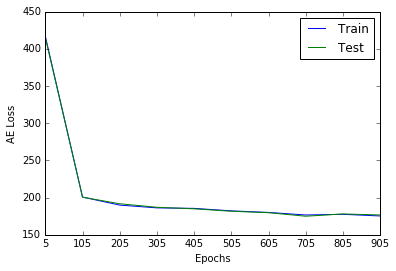

In [74]:
top_save_dir = osp.join(top_data_dir, 'OUT/model_evaluation/variational/', experiment_name)
plot_train_val_test_curves(stats, top_save_dir, has_validation=False, best_epoch=None, show=True)

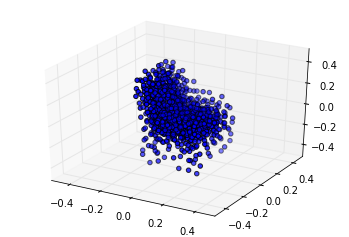

In [51]:
batch_size = conf.batch_size
feed = test_data.next_batch(batch_size)[0].reshape([batch_size] + conf.n_input)
res, loss = vae.reconstruct(feed)
Point_Cloud(points=res[5]).plot(in_u_sphere=True);


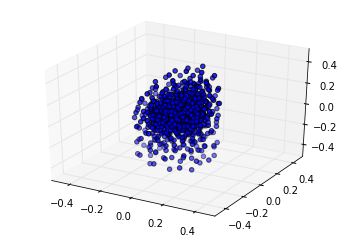

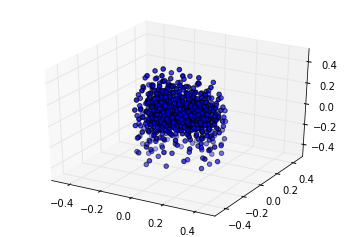

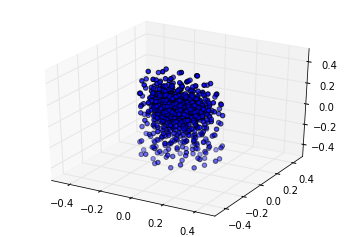

In [77]:
synthetic_data = vae.generate()
Point_Cloud(points=synthetic_data[0]).plot(in_u_sphere=True);
Point_Cloud(points=synthetic_data[1]).plot(in_u_sphere=True);
Point_Cloud(points=synthetic_data[2]).plot(in_u_sphere=True);